In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pickle

In [2]:
data=pd.read_csv("trimmed_data_v3.csv",index_col=0)
data=data[np.isnan(data.vol)]
data.head()

,Date,sec_id,fut_ret,vol,X1,X3,X4,X6,X7,X1_norm,X3_norm,X4_norm,X6_norm,X7_norm,log_vol
17,0.0,0.008538,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180895,-0.080587,-3.438812
59,0.0,0.029633,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180895,-0.080587,-3.438812
68,0.0,0.034154,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180895,-0.080587,-3.438812
106,0.0,0.053240,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180895,-0.080587,-3.438812
109,0.0,0.054746,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180895,-0.080587,-3.438812


In [62]:
print(data.fut_ret.describe())
print(np.percentile(data.fut_ret, 99))

count    20887.000000
mean        -0.000035
std          0.002107
min         -0.077708
25%          0.000000
50%          0.000000
75%          0.000000
max          0.074296
Name: fut_ret, dtype: float64
0.0


In [4]:
split_point=len(data)//4*3
data_train=data.iloc[:split_point]
data_test=data.iloc[split_point:]
print(len(data_train),len(data_test))

15663 5224


## NN

In [3]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
        
        
def NN(data_set, test_set, nodes=[16], epoch=1000, learning_rate=1e-3, is_drop=False, l2_reg=0, is_leaky=False,
        is_batch=False):
    x = torch.tensor(data_set[0], dtype=torch.float32)
    y = torch.tensor(data_set[1][:, np.newaxis], dtype=torch.float32)
    
    # model initialize
    out_size = 1
    F = x.shape[1]
    layer_num = len(nodes)

    # add layers
    model = torch.nn.Sequential()
    model.add_module("linear 0", torch.nn.Linear(F, nodes[0]))
    if is_batch:
        model.add_module("batch 0",torch.nn.BatchNorm1d(nodes[0]))   
    if is_drop:
        model.add_module("drop 0", torch.nn.Dropout(0.5))
    model.add_module("relu 0", torch.nn.ReLU() if not is_leaky else torch.nn.PReLU())
    

    for i in range(layer_num-1):
        model.add_module("linear "+str(i+1),torch.nn.Linear(nodes[i], nodes[i+1]))
        if is_batch:
            model.add_module("batch "+str(i+1),torch.nn.BatchNorm1d(nodes[i+1]))
        if is_drop:
            model.add_module("drop "+str(i+1), torch.nn.Dropout(0.5))
        model.add_module("relu "+str(i+1), torch.nn.ReLU() if not is_leaky else torch.nn.PReLU())
        
    
    # HE initial
    model.apply(init_weights)
    
    #output layer
    model.add_module("linear "+str(layer_num),
                     torch.nn.Linear(nodes[-1], out_size))

    # loss
    loss_fn = torch.nn.MSELoss()    
    #loss_fn=torch.nn.L1Loss()
    
    # optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=l2_reg)

    # training
    loss_history = []
    loss_old=float('inf')
    loss_new=0
    count=0

    for t in range(epoch):
        y_pred = model(x)

        loss_new = loss_fn(y_pred, y)
        
        if abs(loss_old-loss_new)<1e-9:
            count=count+1
        else:
            count=0
            
        if count>30:
            print("converge epoch: ",t)
            break
            
        loss_old = loss_new
        
        #if loss<0.000296:
        #    print("converge epoch: ",t)
        #    break

        if t % 1000== 999:
            print("epoch ", t+1, ", loss is ", loss_new.item())
        #loss_history.append(loss.item())

        optimizer.zero_grad()

        loss_new.backward()

        optimizer.step()

    # plot loss evolution
    #plt.figure(figsize=(14, 7))
    #plt.plot(range(len(loss_history)), loss_history)
    #plt.xlabel("epoch")
    #plt.ylabel("loss")
    #plt.show()

    # testing
    x_test = torch.tensor(test_set[0], dtype=torch.float32)
    y_test = torch.tensor(test_set[1][:, np.newaxis], dtype=torch.float32)
    
    y_in_pred = model(x)
    y_out_pred = model(x_test)
    
    err_in = loss_fn(y_in_pred, y).item()
    err_out = loss_fn(y_out_pred, y_test).item()
    
       
    y=data_set[1]
    y_test=test_set[1]
    y_in_pred=torch.Tensor.numpy(y_in_pred.data)
    y_in_pred.reshape(y_in_pred.shape[0])
    y_out_pred=torch.Tensor.numpy(y_out_pred.data)
    y_out_pred.reshape(y_out_pred.shape[0])
    
    r2_in = r2_score(y, y_in_pred)
    r2_out = r2_score(y_test, y_out_pred)

    #print("\nin-sample error: ", err_in)
    #print("out-of-sample error: ", err_out)
    #print("in-sample r2: ", r2_in)
    #print("out-of-sample r2: ", r2_out)

    return (model,r2_out,err_in)

In [63]:
X_train=np.array(data_train[['sec_id','X1_norm','X3_norm','X4_norm','X6_norm','X7_norm']])
y_train=np.array(data_train['fut_ret'])

train_all=(X_train,y_train)

print(np.shape(X_train),np.shape(y_train))

X_test=np.array(data_test[['sec_id','X1_norm','X3_norm','X4_norm','X6_norm','X7_norm']])
y_test=np.array(data_test['fut_ret'])

test_all=(X_test,y_test)

(15663, 6) (15663,)


In [26]:
def test_r2(model,X = X_test,y = y_test, plot=True):   
    y_pred=model(torch.tensor(Ｘ, dtype=torch.float32))
    y_pred=torch.Tensor.numpy(y_pred.data)
    y_pred=y_pred.reshape(y_pred.shape[0])
    
    if plot:
        plt.figure(figsize=(16,7))
        plt.subplot(1, 2, 1)
        plt.hist(y_pred,range=(-0.1,0.1),bins=30)
        plt.subplot(1, 2, 2)
        plt.hist(y_test,range=(-0.1,0.1),bins=30)
        plt.show()
    r2 = r2_score(y, y_pred)
    return (r2,y_pred)

In [7]:
grid_history=[]

converge epoch:  228
1 :  -0.0001825068249907691    3.166713668179e-06    [32, 16, 8] True 0.1 True True


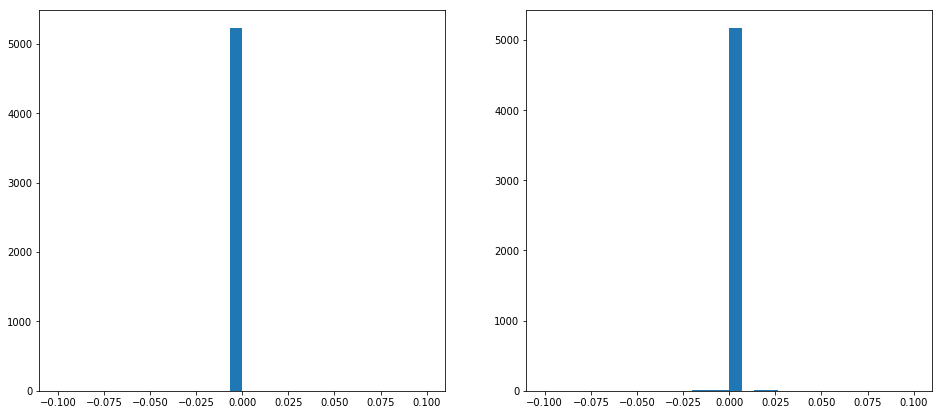

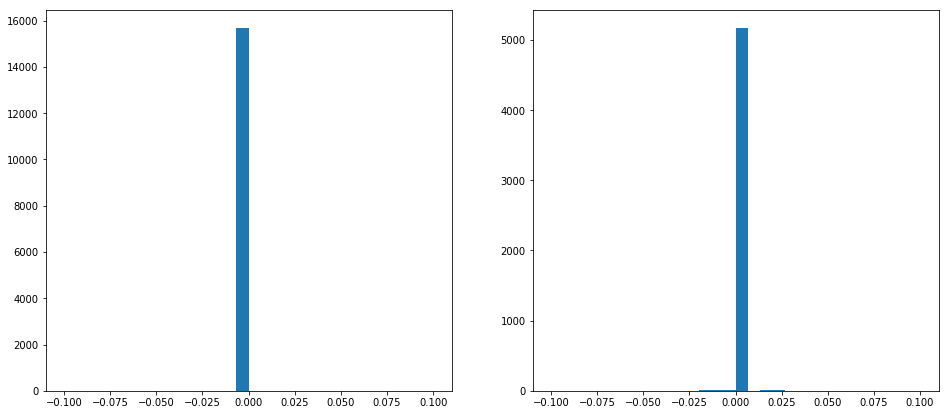

-0.00018250777427541998 , in sample:  -1.0460716518334578e-05 



In [31]:
nodes_list=[
    [32,16,8]
]          

t=1 
for nodes in nodes_list:
    for epoch in [1000]:
        for lr in [1]:
            for isdrop in [True]:
                for l2reg in [1e-1]:
                    for isleaky in [True]:
                        for isbatch in [True]:
                            model,r2,mse=NN(train_all,test_all,nodes, epoch, lr, isdrop, l2reg, isleaky, isbatch)
                            grid_history.append([r2,model,mse,nodes, epoch, lr, isdrop, l2reg, isleaky, isbatch])
                            print(t,": ",r2,"  ",mse,"  ",nodes, isdrop, l2reg, isleaky, isbatch)
                            t=t+1
                            print(test_r2(model)[0],", in sample: ",test_r2(model,X_train,y_train)[0],'\n')


In [32]:
np.mean(test_r2(model,plot=False)[1])

-2.9508607e-05

## Regression

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [85]:
X_train = data_train[['sec_id', 'X1_norm']]
y_train = data_train['fut_ret']

X_test = data_test[['sec_id', 'X1_norm']]
y_test = data_test['fut_ret']

In [87]:
linReg = LinearRegression().fit(X_train, y_train)
print('Linear regression in sample R2:', linReg.score(X_train, y_train))
print('Linear regression out sample R2:',linReg.score(X_test, y_test))
print('Coefficients:', linReg.coef_)

Linear regression in sample R2: 0.0015509987980583118
Linear regression out sample R2: -0.03937824795854494
Coefficients: [8.48376526e-05 5.14849326e-03]


In [52]:
LasReg = Lasso(alpha=6e-5).fit(X_train,y_train)
print('Linear regression in sample R2:', LasReg.score(X_train, y_train))
print('Linear regression out sample R2:',LasReg.score(X_test, y_test))
print('Coefficients:', LasReg.coef_)

Linear regression in sample R2: 0.0
Linear regression out sample R2: -0.00024065086467683905
Coefficients: [ 0.  0.  0. -0. -0. -0.]


In [65]:
r2_score(y_test,np.repeat(np.mean(y_train),len(y_test)))

-0.00024065086467683905

In [69]:
print('Linear regression out sample R2:',linReg.score(X_test, y_test))

Linear regression out sample R2: -0.03937824795854494


In [75]:
np.shape(X_test)

(5224, 6)

In [83]:
def MDA(model,X = X_test,y = y_test):
    feature_num=np.shape(X)[1]
    r2_origin = r2_score(y,model.predict(X))
    print("origin: ",r2_origin)
    for i in range(feature_num):
        r2_new_lst=[]
        for j in range(10):
            X_new=X.copy()
            X_new=np.array(X_new)
            np.random.shuffle(X_new[:,i])
            r2_new=r2_score(y,model.predict(X_new))
            r2_new_lst.append(r2_new)
        is_valid=" *"
        if np.mean(r2_new_lst)>r2_origin:
            is_valid=" "
        if abs(np.mean(r2_new_lst)-r2_origin)/abs(r2_origin)<0.01:
            is_valid=" "
        print("suffle feature ",i,": ",np.mean(r2_new_lst),is_valid)

In [84]:
MDA(linReg)

origin:  -0.03937824795854494
suffle feature  0 :  -0.03930456325767793  
suffle feature  1 :  -0.025442214128260355  
suffle feature  2 :  -0.03937824795854494  
suffle feature  3 :  -0.03937824795854494  
suffle feature  4 :  -0.03937824795854494  
suffle feature  5 :  -0.03937824795854494  
